## Main where we fit over the 30 years matrix and we save the centroids for further analysis

OUTPUT: 
- centroids for different ks

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))
import xarray as xr
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import shapefile as shp
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import joblib
import importlib
import utils.data_processing
import utils.visualization
importlib.reload(utils.data_processing)
importlib.reload(utils.visualization)

# Import the functions 
from utils.visualization import add_country_boundaries
from utils.clusterization import kmeans, elbow_analysis, gap_statistic, silhouette_analysis, davies_bouldin_analysis

The upload of the files, the normalization of the data and the pca are already perfomed and all the results are saved into the matrix _X_pca_60y.npy_.   
Other useful quantities saved in this folder are:   
_global_mean_60y.npy_  
_global_std_60y.npy_  
_ipca_60y.plk_  

All of those quantities were obtained in the jupyter notebook: application_to_10y.ipynb. It uses the code prsente the jupyter notebook creazione_matrice.ipynb and uploading first the file era5_1994_2008.grib and the the file era5_2009_2023.grib

The results of this notebook are saved in the word: Risultati_60y.docx

In [2]:
# 60y
X_pca = np.load("Mid_result_to_save/X_pca_60y.npy")
print(X_pca.shape)

(21915, 20)


In [3]:
#k_max = int(np.sqrt(X_pca.shape[0] / 2))
K_range = range(2,50 + 1)  

# Perform kmeans
results = kmeans(X_pca, K_range=K_range, n_init=20)


In [6]:
# Save the labels 


labels_6 = results["labels"][6]
labels_8 = results["labels"][8]
labels_14 = results["labels"][14]
labels_23 = results["labels"][23]

pd.Series(labels_6).to_csv("Mid_result_to_save/labels_k6.csv", index=False, header=False)
pd.Series(labels_8).to_csv("Mid_result_to_save/labels_k8.csv", index=False, header=False)
pd.Series(labels_14).to_csv("Mid_result_to_save/labels_k14.csv", index=False, header=False)
pd.Series(labels_23).to_csv("Mid_result_to_save/labels_k23.csv", index=False, header=False)

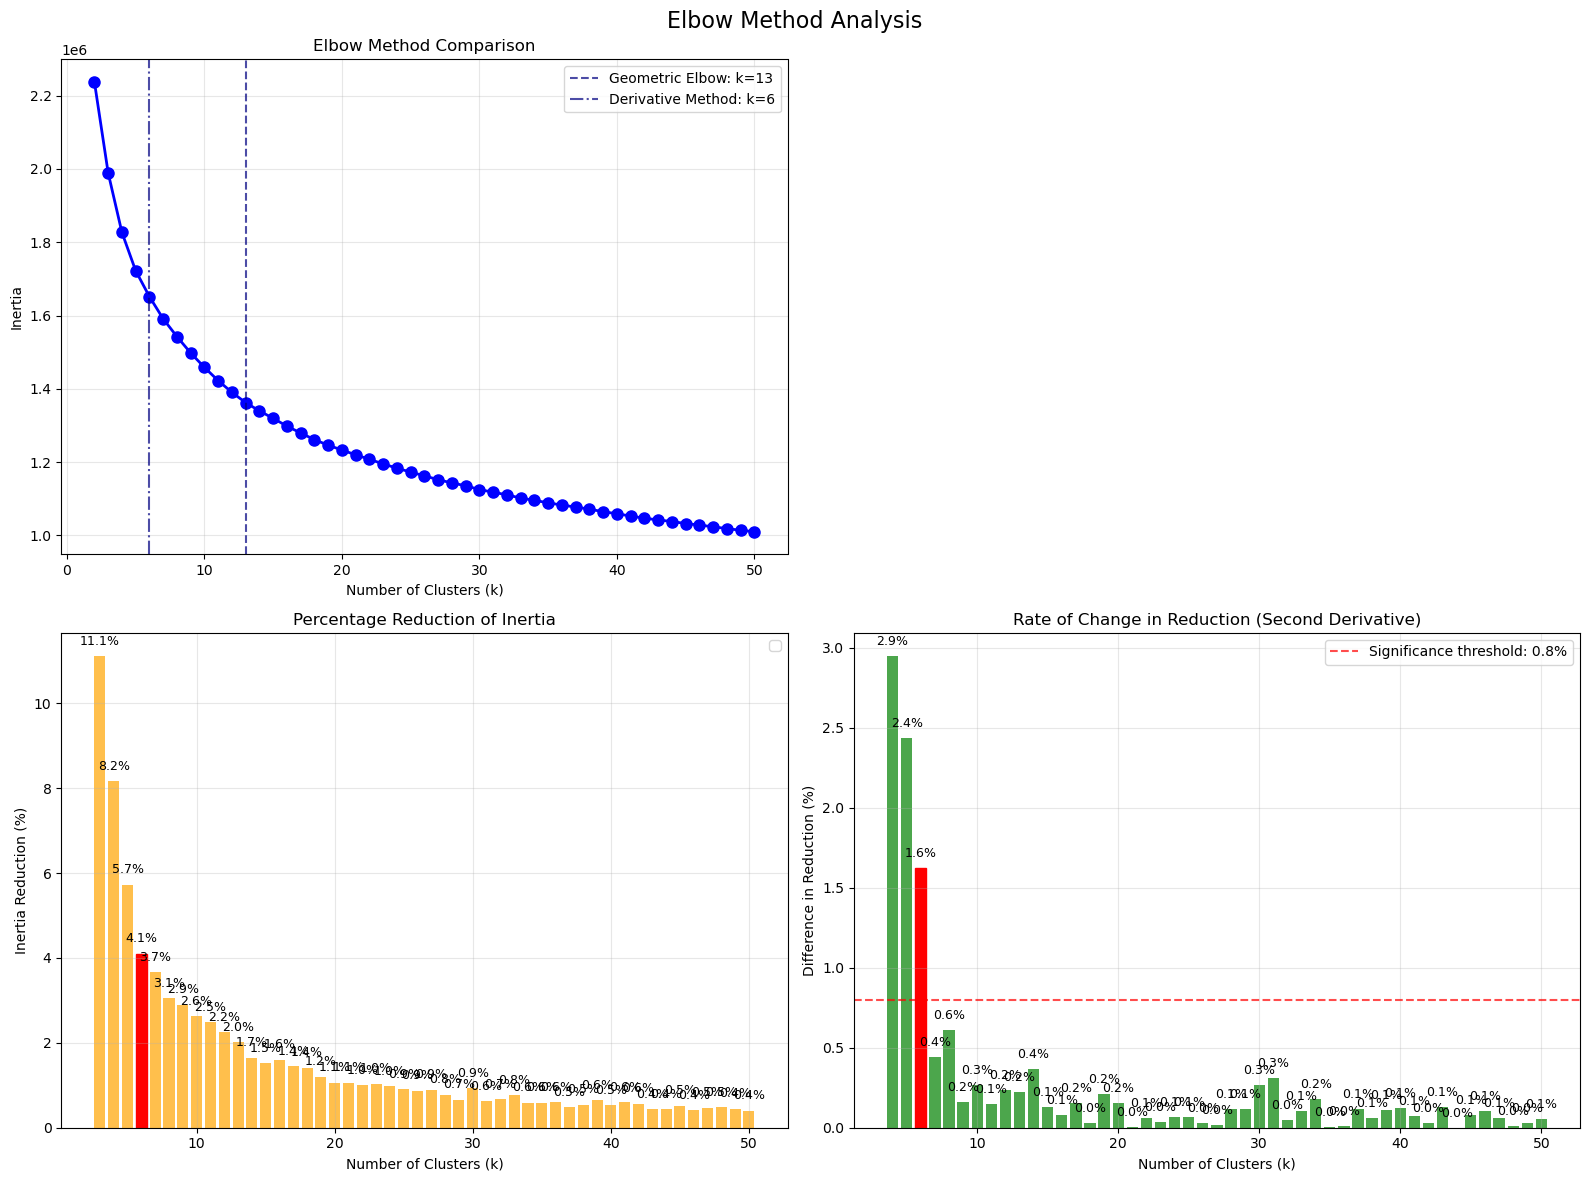

Elbow method suggests k = 13
Derivative method suggests k = 6


In [7]:
# Perform elbow analysis
k_elbow, k_derivative, reductions, _ = elbow_analysis(results) 
print(f"Elbow method suggests k = {k_elbow}")
print(f"Derivative method suggests k = {k_derivative}")


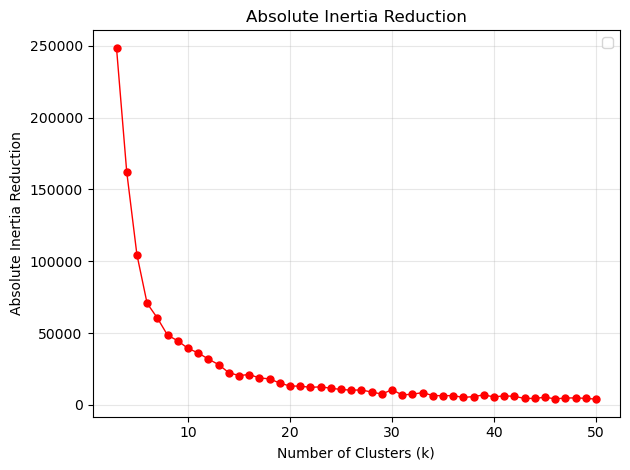

In [8]:
#### Try to see the absolute inertia reduction 
def plot_absolute_inertia_reduction(results):
    """
    Visualization of the absolute inertia reduction between successive k values.
    """

    # Extract data from results
    K_range = results["K_range"]
    inertias = results["inertia"] 

    # Calculate absolute differences
    absolute_reductions = []
    for i in range(1, len(inertias)):
        absolute_diff = inertias[i-1] - inertias[i]  
        absolute_reductions.append(absolute_diff)

    # Plot absolute differences
    k_reductions = list(K_range)[1:]  # k values corresponding to the reductions

    plt.plot(k_reductions, absolute_reductions, 'ro-', linewidth=1, markersize=5)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Absolute Inertia Reduction')
    plt.title('Absolute Inertia Reduction')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Use
plot_absolute_inertia_reduction(results)

In [7]:
# GAP STATISTIC ANALYSIS

# Run the analysis 
##k_optimal, gap_values, error_values = gap_statistic(X_pca, results["K_range"], results)
##print(f"Optimal number of clusters: k = {k_optimal}")

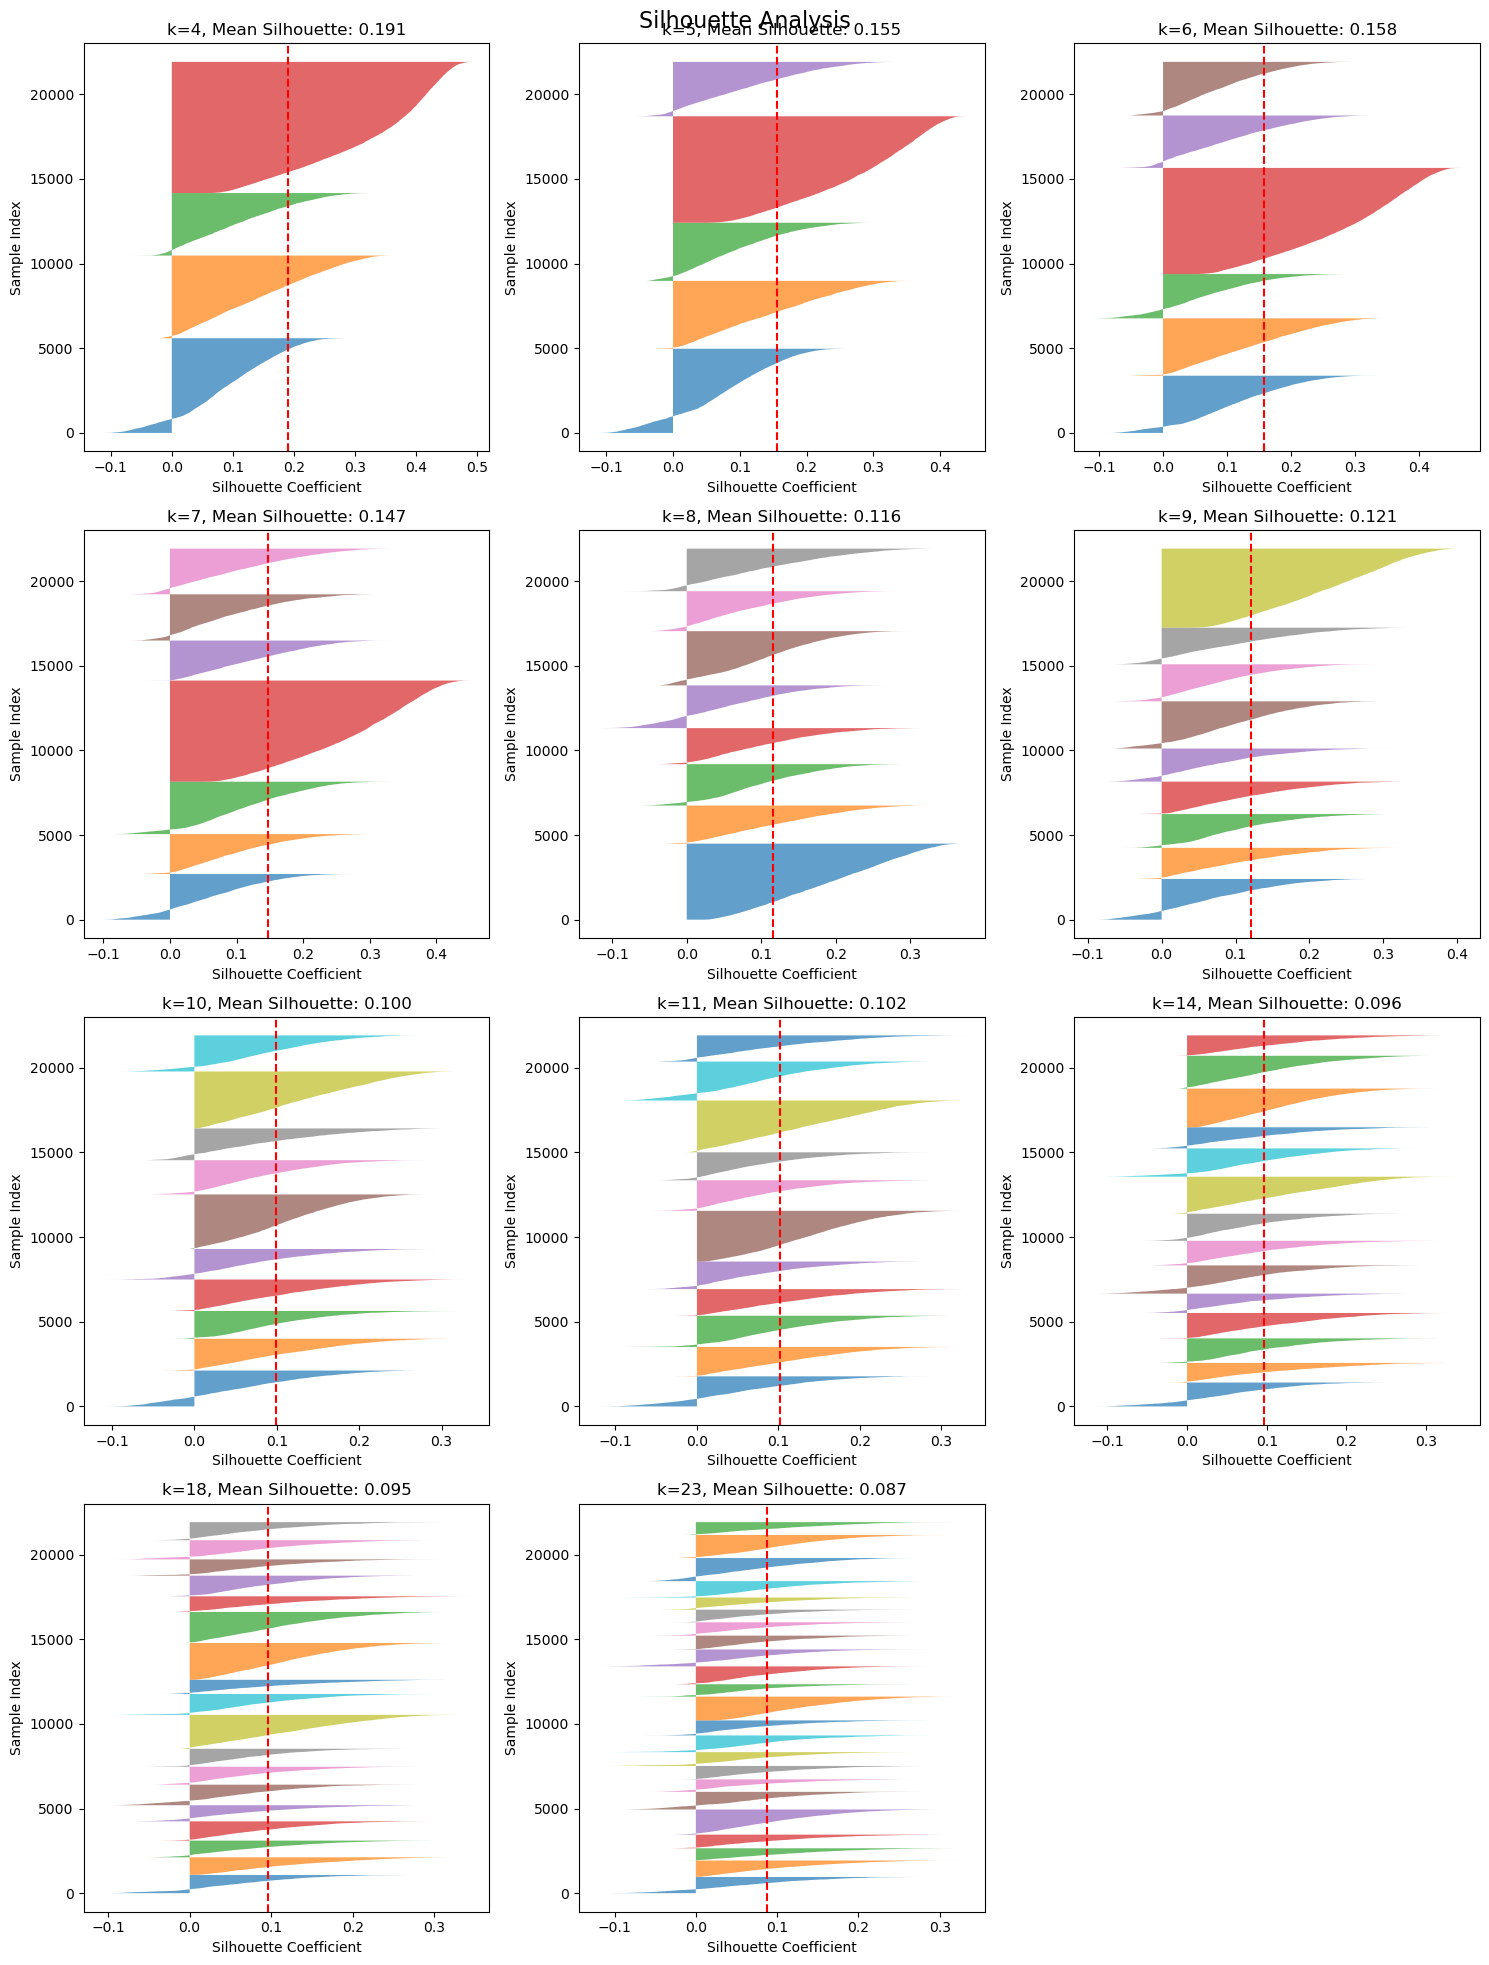

Silhouette Scores:
k=4: 0.191
k=5: 0.155
k=6: 0.158
k=7: 0.147
k=8: 0.116
k=9: 0.121
k=10: 0.100
k=11: 0.102
k=14: 0.096
k=18: 0.095
k=23: 0.087


In [9]:
# SILHOUETTE ANALYSIS FOR CANDIDATE K VALUES

# Run silhouette analysis 
k_candidates = [ 4, 5, 6, 7, 8, 9, 10, 11, 14, 18, 23] 
silhouette_results = silhouette_analysis(X_pca, k_candidates)

print("Silhouette Scores:")
for k, score in zip(k_candidates, silhouette_results):
    print(f"k={k}: {score:.3f}")

Best value for k=4 (DB = 1.849)


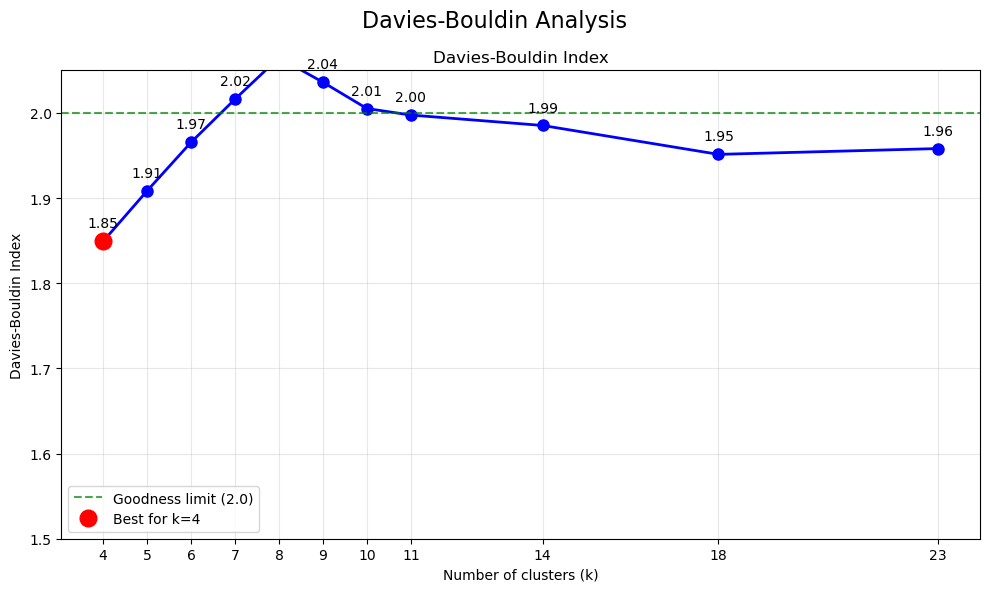


SILHOUETTE vs DAVIES-BOULDIN:
k=4: Silhouette=0.191, Davies-Bouldin=1.849
k=5: Silhouette=0.155, Davies-Bouldin=1.909
k=6: Silhouette=0.158, Davies-Bouldin=1.966
k=7: Silhouette=0.147, Davies-Bouldin=2.016
k=8: Silhouette=0.116, Davies-Bouldin=2.065
k=9: Silhouette=0.121, Davies-Bouldin=2.036
k=10: Silhouette=0.100, Davies-Bouldin=2.005
k=11: Silhouette=0.102, Davies-Bouldin=1.997
k=14: Silhouette=0.096, Davies-Bouldin=1.985
k=18: Silhouette=0.095, Davies-Bouldin=1.951
k=23: Silhouette=0.087, Davies-Bouldin=1.958


In [10]:
db_scores = davies_bouldin_analysis(X_pca, k_candidates, results)

# Confront with Silhouette
print("\nSILHOUETTE vs DAVIES-BOULDIN:")
for i, k in enumerate(k_candidates):
    if i < len(silhouette_results) and i < len(db_scores):
        print(f"k={k}: Silhouette={silhouette_results[i]:.3f}, "
              f"Davies-Bouldin={db_scores[i]:.3f}")

### Clustering Analysis

In [11]:
# Analyze final clustering results
k_final = 6
final_labels= results["labels"][k_final]
final_centroids = results["centroids"][k_final]
print (f"Final centroids shape {final_centroids.shape}")


Final centroids shape (6, 20)


In [13]:
# 60y
np.save(f"Mid_result_to_save/centroids_k{k_final}_60y.npy", final_centroids)

del X_pca
gc.collect()

55352

______________________________

In [14]:
sf = shp.Reader("../world/world-administrative-boundaries.shp")
# Get dimensions from original dataset 
n_lat = 201
n_lon = 321
n_pressure = 2

lats = np.linspace(70.0, 20.0, n_lat)
lons = np.linspace(-40.0, 40.0, n_lon)
pressure_levels = [500, 850]

In [16]:

ipca = joblib.load("Mid_result_to_save/ipca_60y.pkl")
global_mean = np.load("Mid_result_to_save/global_mean_60y.npy")
global_std  = np.load("Mid_result_to_save/global_std_60y.npy")


In [19]:
# Reconstruct meteorological patterns from PCA centroids

def reconstruct_physical_patterns(centroids, ipca, global_mean, global_std):
    """  
    Reconstruct the meteorological patterns from PCA centroids
    """
    # Inverse PCA
    print(f"Input centroids shape: {centroids.shape}")
    centroids_original_space = ipca.inverse_transform(centroids)
    print(f"IPCA inverted: {centroids_original_space.shape}")

    # Destandardization to reobtain the physical values
    centroids_physical = centroids_original_space * global_std + global_mean
    print(f"Destandardized values: {centroids_physical.shape}")
    

    # Reshape for each cluster
    n_lat = 201
    n_lon = 321
    n_pressure = 2
    lats = np.linspace(70.0, 20.0, n_lat)
    lons = np.linspace(-40.0, 40.0, n_lon)
    pressure_levels = [500, 850]
    spatial_size= n_lat * n_lon
    print(f"Spatial dimensions: {n_lat} lat x {n_lon} lon = {spatial_size} points")

    # Reconstruct each cluster pattern
    cluster_patterns = {}

    for cluster_id in range(len(centroids_physical)):
        pattern_vector = centroids_physical[cluster_id] 
        patterns = {}

        # Extract z (geopotential at 500 hPa) - second half of the vector
        z_values = pattern_vector[spatial_size: 2 * spatial_size]   
        z_map = z_values.reshape(n_lat, n_lon)
        patterns['z'] = z_map

        # Extract t (temperature at 850 hPa) - first half of the vector
        t_values = pattern_vector[:spatial_size]  
        t_map = t_values.reshape(n_lat, n_lon)
        patterns['t'] = t_map

        cluster_patterns[cluster_id] = patterns
        print(f"Cluster {cluster_id}: Z {z_map.shape} - Range [{z_map.min():.1f}, {z_map.max():.1f}]")
        print(f"Cluster {cluster_id}: T {t_map.shape} - Range [{t_map.min():.1f}, {t_map.max():.1f}]")

    return cluster_patterns

# Reconstruct the patterns
cluster_patterns = reconstruct_physical_patterns(final_centroids, ipca, global_mean, global_std)

Input centroids shape: (6, 20)
IPCA inverted: (6, 129042)
Destandardized values: (6, 129042)
Spatial dimensions: 201 lat x 321 lon = 64521 points
Cluster 0: Z (201, 321) - Range [52543.2, 57643.3]
Cluster 0: T (201, 321) - Range [266.4, 298.2]
Cluster 1: Z (201, 321) - Range [50329.0, 57264.4]
Cluster 1: T (201, 321) - Range [254.5, 290.4]
Cluster 2: Z (201, 321) - Range [53831.4, 58081.8]
Cluster 2: T (201, 321) - Range [271.3, 302.6]
Cluster 3: Z (201, 321) - Range [50504.1, 57282.8]
Cluster 3: T (201, 321) - Range [257.4, 292.5]
Cluster 4: Z (201, 321) - Range [52049.4, 57666.2]
Cluster 4: T (201, 321) - Range [263.2, 297.2]
Cluster 5: Z (201, 321) - Range [50572.2, 57321.2]
Cluster 5: T (201, 321) - Range [258.9, 293.3]


METEOROLOGICAL MAPS OF THE CLUSTERS
CLUSTER 0:


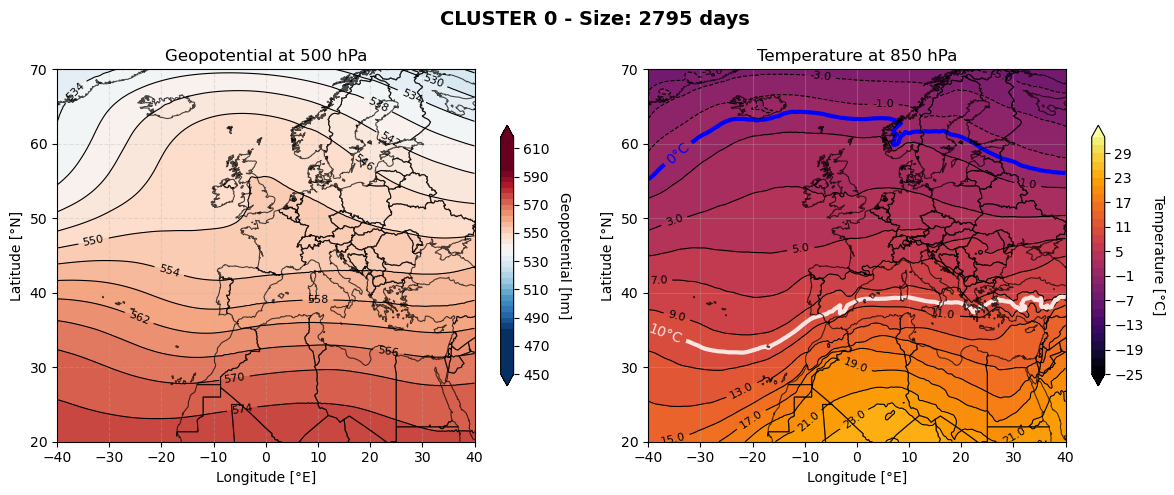


 CLUSTER STATISTICS: 0
Geopotential 500 hPa:
   • Mean: 555 hm
   • Range: 525 - 576 hm
   • Variability: 12 hm
Temperature 850 hPa:
   • Mean: 280.3 K (7.2°C)
   • Range: -6.8 - 25.1 K
   • Variability: 7.5 K
CLUSTER 1:


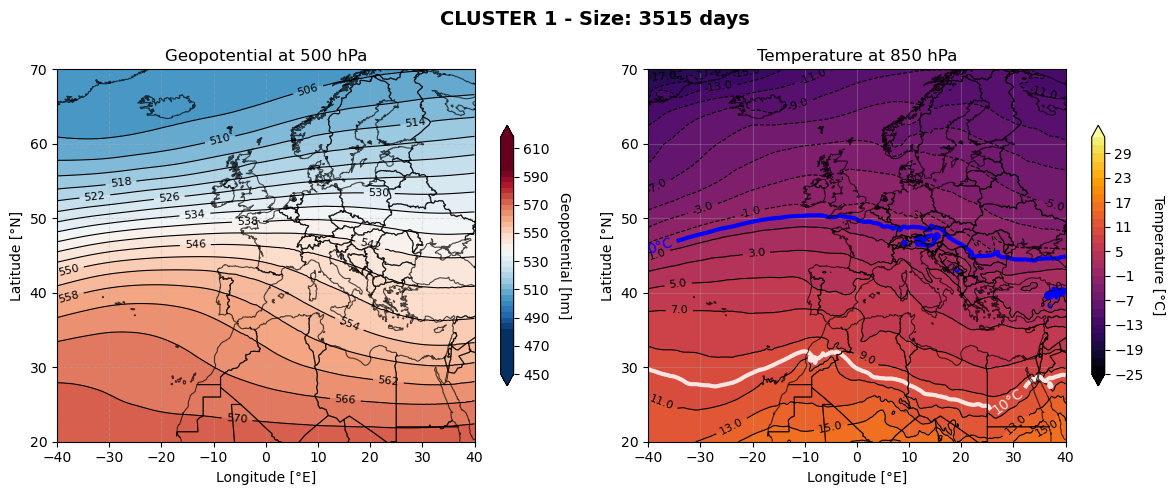


 CLUSTER STATISTICS: 1
Geopotential 500 hPa:
   • Mean: 541 hm
   • Range: 503 - 573 hm
   • Variability: 23 hm
Temperature 850 hPa:
   • Mean: 274.6 K (1.4°C)
   • Range: -18.6 - 17.3 K
   • Variability: 7.9 K
CLUSTER 2:


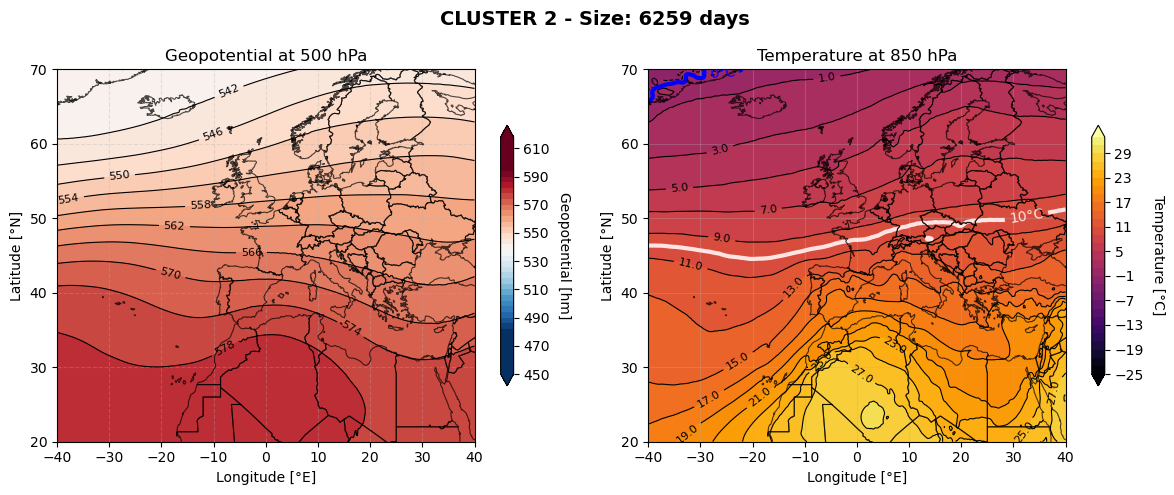


 CLUSTER STATISTICS: 2
Geopotential 500 hPa:
   • Mean: 564 hm
   • Range: 538 - 581 hm
   • Variability: 13 hm
Temperature 850 hPa:
   • Mean: 285.4 K (12.3°C)
   • Range: -1.9 - 29.5 K
   • Variability: 7.9 K
CLUSTER 3:


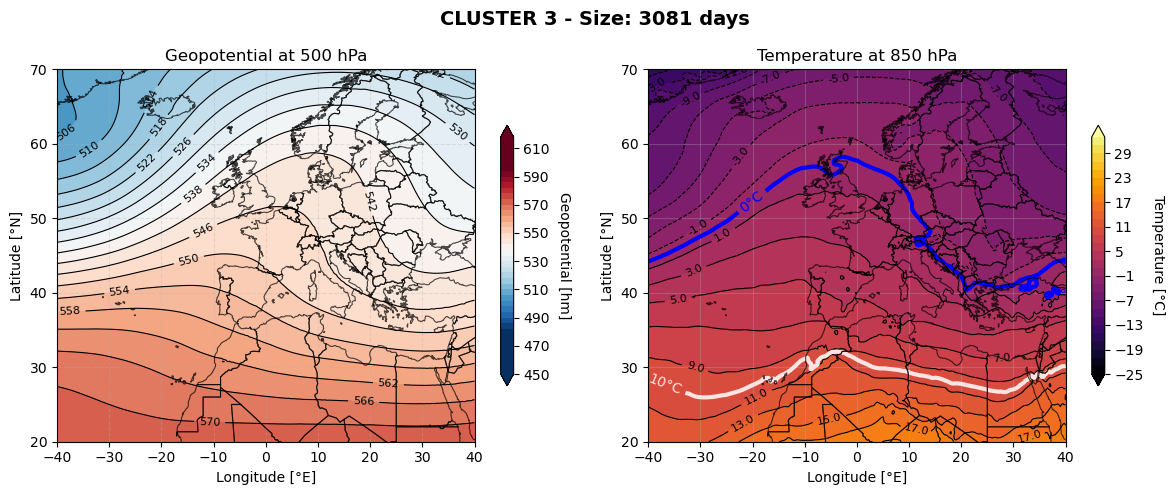


 CLUSTER STATISTICS: 3
Geopotential 500 hPa:
   • Mean: 545 hm
   • Range: 505 - 573 hm
   • Variability: 17 hm
Temperature 850 hPa:
   • Mean: 275.6 K (2.4°C)
   • Range: -15.8 - 19.3 K
   • Variability: 7.0 K
CLUSTER 4:


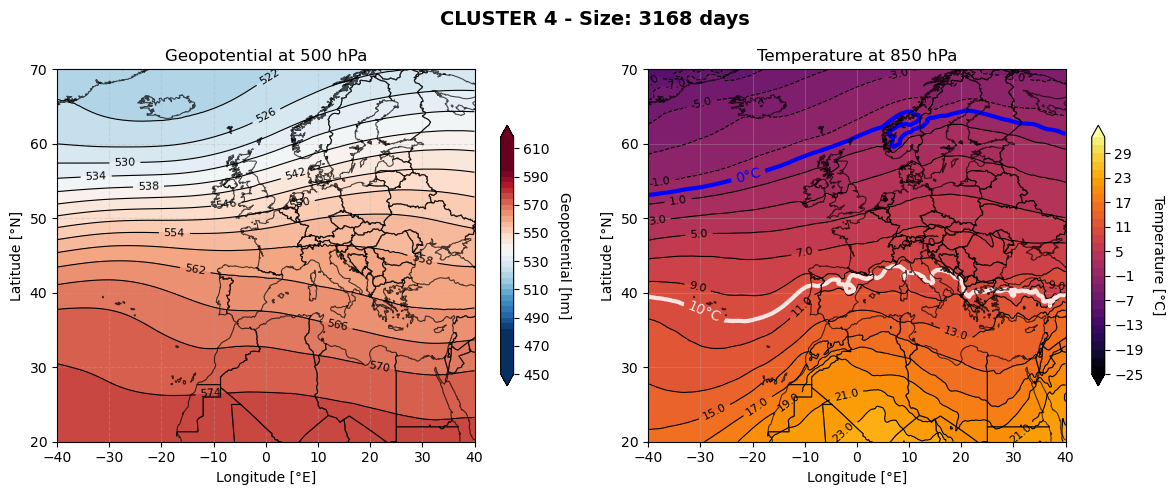


 CLUSTER STATISTICS: 4
Geopotential 500 hPa:
   • Mean: 554 hm
   • Range: 520 - 577 hm
   • Variability: 18 hm
Temperature 850 hPa:
   • Mean: 280.8 K (7.7°C)
   • Range: -10.0 - 24.1 K
   • Variability: 7.8 K
CLUSTER 5:


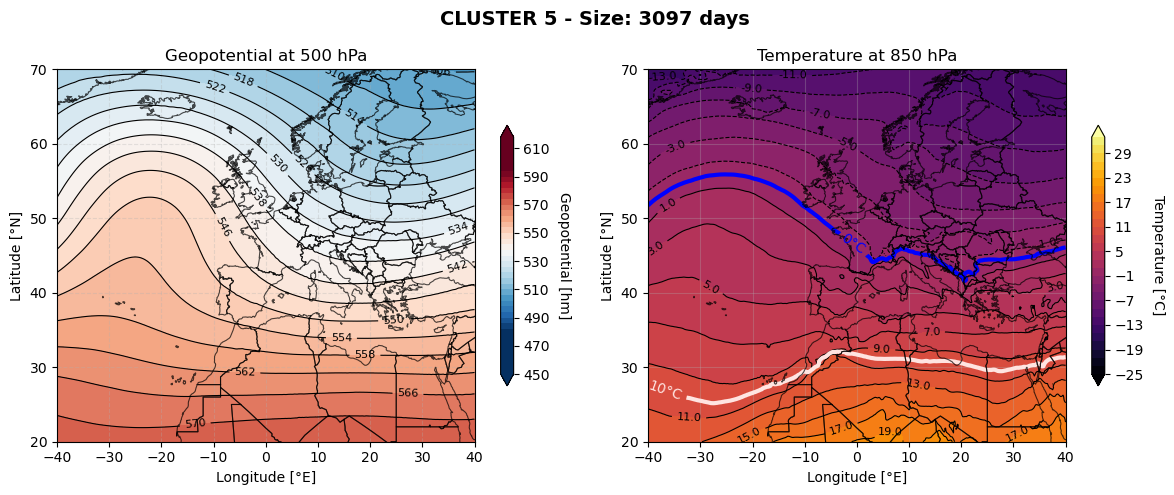


 CLUSTER STATISTICS: 5
Geopotential 500 hPa:
   • Mean: 544 hm
   • Range: 506 - 573 hm
   • Variability: 18 hm
Temperature 850 hPa:
   • Mean: 275.0 K (1.9°C)
   • Range: -14.3 - 20.2 K
   • Variability: 8.1 K


In [20]:
# Visualize the meteorological maps for each cluster
def plot_cluster_meteorological_maps(cluster_patterns, lats, lons, sf=None):
    """
    Visualizes the meteorological maps
    """
    # Fixed levels for geopotential
    z_levels_fixed = np.arange(450, 620, 4)  
    z_vmin, z_vmax = 480, 595

    # Fixed levels for temperature
    t_levels_fixed = np.arange(-25, 35, 2)  
    t_vmin, t_vmax = -25, 35
    
    for cluster_id, pattern in cluster_patterns.items():
        # Compute the number of elements in the cluster
        cluster_size = np.sum(final_labels == cluster_id)
        print(f"CLUSTER {cluster_id}:")
        
        # Create the plots
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        lon_grid, lat_grid = np.meshgrid(lons, lats)
        
        # PLOT GEOPOTENTIAL (Z)
        ax = axes[0]
        z_data = pattern['z']  
        z_data_hm = z_data / 100 

        
        contour_z = ax.contourf(lon_grid, lat_grid, z_data_hm,
                               levels=z_levels_fixed, cmap='RdBu_r',vmin=z_vmin, vmax=z_vmax, extend='both')

        contour_lines_z = ax.contour(lon_grid, lat_grid, z_data_hm,
                                    levels=z_levels_fixed, colors='black', linewidths=0.8)
        ax.clabel(contour_lines_z, inline=True, fontsize=8, fmt='%.0f')

        # European boundaries
        if sf is not None:
            add_country_boundaries(ax, sf)
                
        # Styling
        ax.set_title(f'Geopotential at 500 hPa')
        ax.set_xlabel('Longitude [°E]')
        ax.set_ylabel('Latitude [°N]')
        ax.set_xlim([lons.min(), lons.max()])
        ax.set_ylim([lats.min(), lats.max()])
        ax.grid(True, alpha=0.3, linestyle='--')
                
        # Colorbar
        cbar_z = plt.colorbar(contour_z, ax=ax, shrink=0.7)
        cbar_z.set_label('Geopotential [hm]', rotation=270, labelpad=15)

        # PLOT TEMPERATURE (T)
        ax = axes[1]
        t_data = pattern['t']  
        t_data_celsius = t_data - 273.15
        
        # Contour plot 
        contour_t = ax.contourf(lon_grid, lat_grid, t_data_celsius, 
                               levels=t_levels_fixed, cmap='inferno', extend='both', vmin= t_vmin, vmax=t_vmax)

        
        contour_lines_t = ax.contour(lon_grid, lat_grid, t_data_celsius, 
                                    levels=t_levels_fixed, colors='black', linewidths=0.8)
        ax.clabel(contour_lines_t, inline=True, fontsize=8, fmt='%.1f')

        # Contour lines for 0°C and 10°C
        zero_contour = ax.contour(lon_grid, lat_grid, t_data_celsius, 
                                 levels=[0], colors='blue', 
                                 linewidths=3, linestyles='-')
        ax.clabel(zero_contour, inline=True, fontsize=10, fmt='0°C', colors='blue')

        ten_contour = ax.contour(lon_grid, lat_grid, t_data_celsius, 
                                 levels=[10], colors='mistyrose', 
                                 linewidths=3, linestyles='-')
        ax.clabel(ten_contour, inline=True, fontsize=10, fmt='10°C', colors='mistyrose')

        # European boundaries
        if sf is not None:
            add_country_boundaries(ax, sf)
        
        # Styling
        ax.set_title('Temperature at 850 hPa')
        ax.set_xlabel('Longitude [°E]')
        ax.set_ylabel('Latitude [°N]')
        ax.set_xlim([lons.min(), lons.max()])
        ax.set_ylim([lats.min(), lats.max()])
        ax.grid(True, alpha=0.3)
        
        # Colorbar
        cbar_t = plt.colorbar(contour_t, ax=ax, shrink=0.7)
        cbar_t.set_label('Temperature [°C]', rotation=270, labelpad=15)

        # General title
        fig.suptitle(f'CLUSTER {cluster_id} - Size: {cluster_size} days',
                    fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()

        print_cluster_stats(cluster_id, pattern)

def print_cluster_stats(cluster_id, pattern):
    """
    Prints simple statistics for the cluster
    """
    print(f"\n CLUSTER STATISTICS: {cluster_id}")

    # Geopotential
    z_data = pattern['z']
    z_data_hm = z_data / 100
    print(f"Geopotential 500 hPa:")
    print(f"   • Mean: {z_data_hm.mean():.0f} hm")
    print(f"   • Range: {z_data_hm.min():.0f} - {z_data_hm.max():.0f} hm")
    print(f"   • Variability: {z_data_hm.std():.0f} hm")

    # Temperature
    t_data = pattern['t']
    t_data_celsius = t_data - 273.15
    print(f"Temperature 850 hPa:")
    print(f"   • Mean: {t_data.mean():.1f} K ({t_data_celsius.mean():.1f}°C)")
    print(f"   • Range: {t_data_celsius.min():.1f} - {t_data_celsius.max():.1f} K")
    print(f"   • Variability: {t_data_celsius.std():.1f} K")

#  ESECUZIONE SEMPLIFICATA
print("METEOROLOGICAL MAPS OF THE CLUSTERS")


plot_cluster_meteorological_maps(cluster_patterns, lats, lons, sf)


In [21]:
def find_most_representative_days(cluster_id, final_labels, final_centroids, X_pca, n_days = 1):
    """
    Finds the most representative days for a given cluster based on proximity to the centroid.
    """
    # Find all days belonging to the cluster
    cluster_mask = final_labels == cluster_id
    cluster_points = X_pca[cluster_mask]
    centroid = final_centroids[cluster_id]
    
    # Compute Euclidean distances from the centroid
    distances = np.linalg.norm(cluster_points - centroid, axis=1)

    # Find the index of the closest point (minimum distance)
    closest_idx_in_cluster = np.argsort(distances)[:n_days]
    
    # Find the original indices in the full dataset
    original_indices = np.where(cluster_mask)[0]
    most_representative_day_idx = original_indices[closest_idx_in_cluster]
    
    return most_representative_day_idx, distances[closest_idx_in_cluster]

In [26]:
#load X_pca
X_pca = np.load("Mid_result_to_save/X_pca_60y.npy")

In [27]:
def analyze_representative_days(cluster_patterns, final_labels, final_centroids, X_pca, ds_filtered):
    """
    Analyses the most representative days for each cluster and computes statistics.
    """
    representative_days = {}
    
    print("TOP 3 MOST REPRESENTATIVE DAYS PER CLUSTER:")
    
    for cluster_id in range(len(final_centroids)):
        # Find the most representative day
        day_indices, distances = find_most_representative_days(
            cluster_id, final_labels, final_centroids, X_pca, n_days=3)

        # Extract the dates
        dates = pd.to_datetime(ds_filtered.time.values)
        representative_dates = dates[day_indices]
        
        # Compute cluster statistics
        cluster_mask = final_labels == cluster_id
        cluster_size = np.sum(cluster_mask)
        all_distances = np.linalg.norm(X_pca[cluster_mask] - final_centroids[cluster_id], axis=1)
        mean_distance = np.mean(all_distances)
        
        # Compute representativity as a percentage
        representativities = [(1 - dist/mean_distance)*100 for dist in distances]
        
        representative_days[cluster_id] = {
            'day_indices': day_indices,  
            'dates': representative_dates,  
            'distances': distances,
            'cluster_size': cluster_size,
            'mean_distance_in_cluster': mean_distance,
            'representativities': representativities
        }
        
        print(f"\nCluster {cluster_id} ({cluster_size} giorni):")
        for i, (date, dist, repr_val) in enumerate(zip(representative_dates, distances, representativities)):
            print(f"  {i+1}. {date.strftime('%Y-%m-%d')} - Distanza: {dist:.3f} - Rappresentatività: {repr_val:.1f}%")
    
    return representative_days

def plot_real_meteorological_maps(representative_days, ds_filtered, sf=None):
    """
    Visualizes the meteorological maps of the 3 most representative real days for each cluster
    """

    # Fixed levels for geopotential
    z_levels_fixed = np.arange(450, 620, 4)  
    z_vmin, z_vmax = 480, 595

    # Fixed levels for temperature
    t_levels_fixed = np.arange(-25, 35, 2)  
    t_vmin, t_vmax = -25, 35
    
    for cluster_id, day_info in representative_days.items():
        day_indices = day_info['day_indices']  
        dates = day_info['dates']  
        distances = day_info['distances']
        representativities = day_info['representativities']
        
        print(f"CLUSTER {cluster_id} - TOP 3 GIORNI PIÙ RAPPRESENTATIVI")
        for i, (date, repr_val) in enumerate(zip(dates, representativities)):
            print(f"  {i+1}. {date.strftime('%d-%m-%Y (%A)')} - Rappresentatività: {repr_val:.1f}%")

        fig, axes = plt.subplots(3, 2, figsize=(12, 10))
        lon_grid, lat_grid = np.meshgrid(lons, lats)
        
        for day_idx, (day_index, date, distance, representativity) in enumerate(
            zip(day_indices, dates, distances, representativities)): 

            # Extract data for that day
            if 'z' in ds_filtered.data_vars:
                z_data = ds_filtered['z'].isel(time=day_index)
                # Manage dimensions
                if 'pressure_z' in z_data.dims:
                    z_data = z_data.isel(pressure_z=0)
                
            if 't' in ds_filtered.data_vars:
                t_data = ds_filtered['t'].isel(time=day_index)
                # Manage dimensions
                if 'pressure_t' in t_data.dims:
                    t_data = t_data.isel(pressure_t=0)
            
            # PLOT GEOPOTENTIAL 
            if 'z' in ds_filtered.data_vars:
                ax = axes[day_idx, 0]
                
                lons_grid, lats_grid = np.meshgrid(z_data.longitude, z_data.latitude)
                data_hm = z_data.values / 100
                
                # Contour plot
                contour_filled = ax.contourf(lons_grid, lats_grid, data_hm, 
                                           levels=z_levels_fixed , cmap='RdBu_r', extend='both', vmin=z_vmin, vmax=z_vmax)
                contour_lines = ax.contour(lons_grid, lats_grid, data_hm, 
                                         z_levels_fixed = z_levels_fixed, colors='black', linewidths=0.6)
                ax.clabel(contour_lines, inline=True, fontsize=7, fmt='%.0f')
                
                # Confini europei
                if sf is not None:
                    add_country_boundaries(ax, sf)
                
                # Styling
                if day_idx == 0:
                    ax.set_title('Geopotential at 500 hPa [hm]', fontsize=10, fontweight='bold')
                ax.set_ylabel(f'Day {day_idx+1}\n{date.strftime("%d-%m-%Y")}', fontsize=9)
                ax.set_xlim([z_data.longitude.min(), z_data.longitude.max()])
                ax.set_ylim([z_data.latitude.min(), z_data.latitude.max()])
                ax.grid(True, alpha=0.3)
                
                # Remove x labels except last row
                if day_idx < 2:
                    ax.set_xticklabels([])
                else:
                    ax.set_xlabel('Longitude [°E]', fontsize=9)
                
                cbar = plt.colorbar(contour_filled, ax=ax, shrink=0.6)
                cbar.set_label('[hm]', rotation=270, labelpad=10, fontsize=8)

            # PLOT TEMPERATURE 
            if 't' in ds_filtered.data_vars:
                ax = axes[day_idx, 1]               
                
                lons_grid, lats_grid = np.meshgrid(t_data.longitude, t_data.latitude)
                              
                data_celsius = t_data.values - 273.15
                
                # Contour plot
                contour_filled = ax.contourf(lons_grid, lats_grid, data_celsius, 
                                           levels=t_levels_fixed, cmap='inferno', extend='both', vmin=t_vmin, vmax=t_vmax)
                contour_lines = ax.contour(lons_grid, lats_grid, data_celsius, 
                                         levels=t_levels_fixed, colors='black', linewidths=0.6)
                ax.clabel(contour_lines, inline=True, fontsize=7, fmt='%.1f')

                zero_contour = ax.contour(lon_grid, lat_grid, data_celsius, 
                                 levels=[0], colors='blue', 
                                 linewidths=3, linestyles='-')
                ax.clabel(zero_contour, inline=True, fontsize=10, fmt='0°C', colors='blue')

                ten_contour = ax.contour(lon_grid, lat_grid, data_celsius, 
                                 levels=[10], colors='mistyrose', 
                                 linewidths=3, linestyles='-')
                ax.clabel(ten_contour, inline=True, fontsize=10, fmt='10°C', colors='mistyrose')
                
                # European boundaries
                if sf is not None:
                    add_country_boundaries(ax, sf)
                
                # Styling
                if day_idx == 0:
                    ax.set_title('Temperature at 850 hPa [°C]', fontsize=10, fontweight='bold')
                ax.set_xlim([t_data.longitude.min(), t_data.longitude.max()])
                ax.set_ylim([t_data.latitude.min(), t_data.latitude.max()])
                ax.grid(True, alpha=0.3)
                
                if day_idx < 2:
                    ax.set_xticklabels([])
                else:
                    ax.set_xlabel('Longitude [°E]', fontsize=9)
                
                ax.set_yticklabels([])
                
                # Colorbar 
                cbar = plt.colorbar(contour_filled, ax=ax, shrink=0.6)
                cbar.set_label('[°C]', rotation=270, labelpad=10, fontsize=8)
        
        # General Title
        fig.suptitle(f'CLUSTER {cluster_id} - TOP 3 MOST REPRESENTATIVE DAYS', 
                    fontsize=12, fontweight='bold', y=0.98)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.94)
        plt.show()


print("ANALYSIS OF THE TOP 3 MOST REPRESENTATIVE DAYS")
# representative_days = analyze_representative_days(cluster_patterns, final_labels, final_centroids, X_pca, ds_filtered)   # demarco se voglio

print("_ _ _ _ _ _ _ _ _")
print("\nVISUALIZATION OF REPRESENTATIVE DAYS") 
# plot_real_meteorological_maps(representative_days, ds_filtered, sf)     # Use it If needed

ANALYSIS OF THE TOP 3 MOST REPRESENTATIVE DAYS
_ _ _ _ _ _ _ _ _

VISUALIZATION OF REPRESENTATIVE DAYS


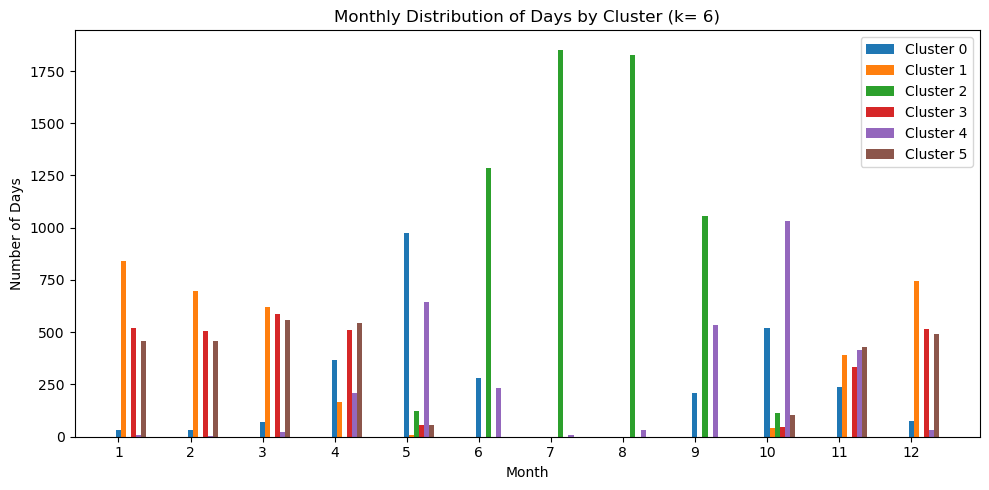

In [28]:
n_clusters = k_final

dates = pd.date_range(start="1961-01-01", end="2020-12-31", freq="D")
df_temporal = pd.DataFrame({
    'date': dates,
    'cluster': final_labels,  
    'month': dates.month,
    'year': dates.year
})

fig, ax = plt.subplots(figsize=(10, 5))
for cluster_id in range(n_clusters):
    monthly_counts = df_temporal[df_temporal['cluster'] == cluster_id]['month'].value_counts().sort_index()
    ax.bar(monthly_counts.index + cluster_id*0.07, monthly_counts.values, width=0.07, label=f'Cluster {cluster_id}')

ax.set_xticks(range(1, 13))
ax.set_xlabel('Month')
ax.set_ylabel('Number of Days')
ax.set_title(f'Monthly Distribution of Days by Cluster (k= {n_clusters})')
ax.legend()
plt.tight_layout()
plt.show()

Contingency table (rows: cluster k=6, columns: cluster k=8):
Contingency table (rows: cluster k=6, columns: cluster k=14):
Contingency table (rows: cluster k=14, columns: cluster k=23):


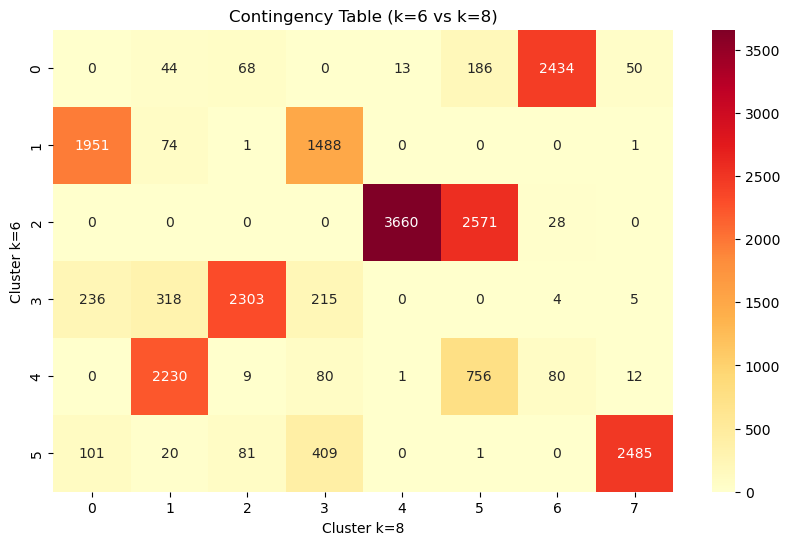

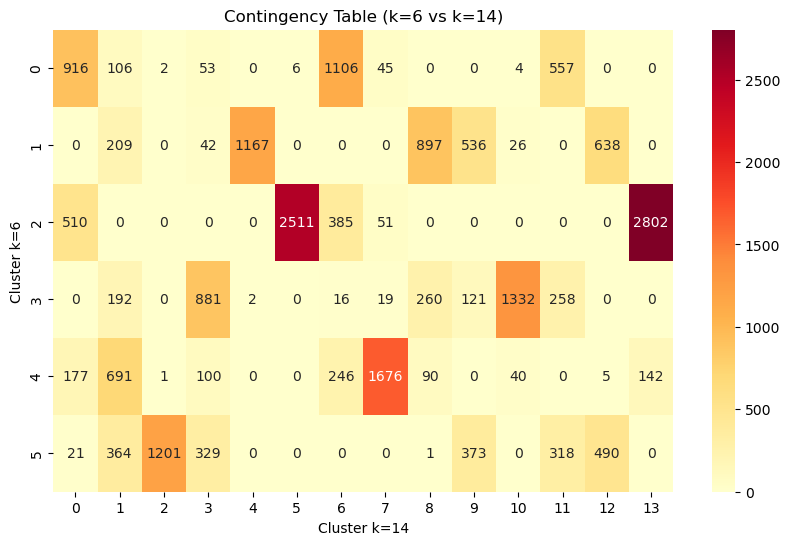

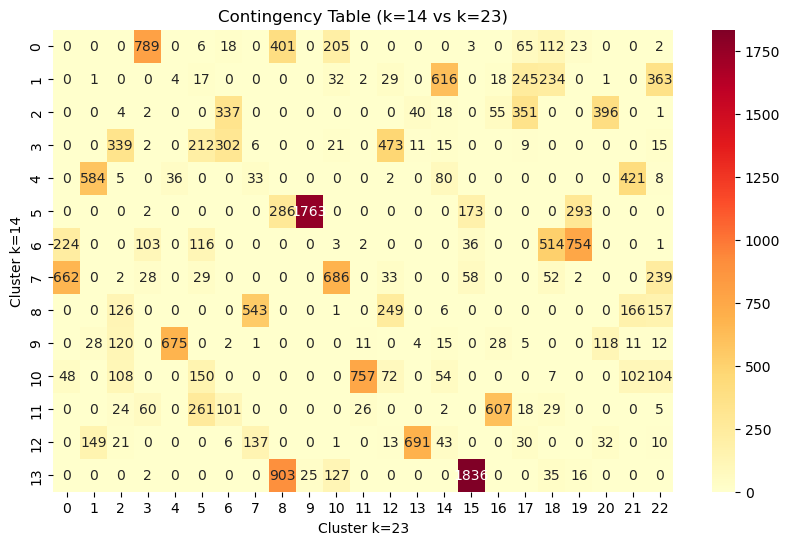

In [29]:
# Load other clustering results
labels_6 = pd.read_csv("Mid_result_to_save/labels_k6.csv", header=None).squeeze("columns")
labels_8 = pd.read_csv("Mid_result_to_save/labels_k8.csv", header=None).squeeze("columns")
labels_14 = pd.read_csv("Mid_result_to_save/labels_k14.csv", header=None).squeeze("columns")
labels_23 = pd.read_csv("Mid_result_to_save/labels_k23.csv", header=None).squeeze("columns")

# Create the contingency table
contingency_6_8 = pd.crosstab(labels_6, labels_8)
print("Contingency table (rows: cluster k=6, columns: cluster k=8):")
#print(contingency_6_18)

contingency_6_14 = pd.crosstab(labels_6, labels_14)
print("Contingency table (rows: cluster k=6, columns: cluster k=14):")


contingency_14_23 = pd.crosstab(labels_14, labels_23)
print("Contingency table (rows: cluster k=14, columns: cluster k=23):")
#print(contingency_6_10)

plt.figure(figsize=(10, 6))
sns.heatmap(contingency_6_8, annot=True, fmt="d", cmap="YlOrRd")
plt.title("Contingency Table (k=6 vs k=8)")
plt.xlabel("Cluster k=8")
plt.ylabel("Cluster k=6")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(contingency_6_14, annot=True, fmt="d", cmap="YlOrRd")
plt.title("Contingency Table (k=6 vs k=14)")
plt.xlabel("Cluster k=14")
plt.ylabel("Cluster k=6")
#plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(contingency_14_23, annot=True, fmt="d", cmap="YlOrRd")
plt.title("Contingency Table (k=14 vs k=23)")
plt.xlabel("Cluster k=23")
plt.ylabel("Cluster k=14")
plt.show()



_______________

Now we have saved the centroids, so we load the six 10-years files and we assign each element to the nearest centroid --> see the notebook: 4-test_over_10y.ipynb